In [1]:
using Graphs
using Plots
using GraphPlot, LightGraphs
using Measures
using Compose, Cairo, Fontconfig

using Agents, Random 
using CairoMakie

In [2]:
###space = GridSpaceSingle((10, 10); periodic = false)

In [3]:
@agent SchellingAgent GridAgent{2} begin
    mood::Bool # whether the agent is happy in its position. (true = happy)
    group::Int # The group of the agent, determines mood as it interacts with neighbors
end

In [4]:
for (name, type) in zip(fieldnames(SchellingAgent), fieldtypes(SchellingAgent))
    println(name, "::", type)
end

id::Int64
pos::Tuple{Int64, Int64}
mood::Bool
group::Int64


### Creating an ABM

In [5]:
function initialize(; total_agents = 10, griddims = (7, 7), min_to_be_happy = 3, seed = 125)
    space = GridSpaceSingle(griddims, periodic = false)
    properties = Dict(:min_to_be_happy => min_to_be_happy)
    rng = Random.Xoshiro(seed)
    model = UnremovableABM(
        SchellingAgent, space;
        properties, rng, scheduler = Schedulers.Randomly()
    )
    
    # populate the model with agents, adding equal amount of the two types of agents
    # at random positions in the model
    for n in 1:total_agents
        agent = SchellingAgent(n, (1, 1), false, n < total_agents / 2 ? 1 : 2)
        add_agent_single!(agent, model)
    end
    return model
end

initialize (generic function with 1 method)

In [6]:
function agent_step!(agent, model)
    minhappy = model.min_to_be_happy
    count_neighbors_same_group = 0
    # For each neighbor, get group and compare to current agent's group
    # and increment `count_neighbors_same_group` as appropriately.
    # Here `nearby_agents` (with default arguments) will provide an iterator
    # over the nearby agents one grid point away, which are at most 8.
    
    for neighbor in nearby_agents(agent, model)
        if agent.group == neighbor.group
            count_neighbors_same_group += 1
        end
    end
    # After counting the neighbors, decide whether or not to move the agent.
    # If count_neighbors_same_group is at least the min_to_be_happy, set the
    # mood to true. Otherwise, move the agent to a random position, and set
    # mood to false.
    if count_neighbors_same_group ≥ minhappy
        agent.mood = true
    else
        agent.mood = false
        move_agent_single!(agent, model)
    end
    return
end

agent_step! (generic function with 1 method)

### Initial Graph

In [7]:
model = initialize()

UnremovableABM with 10 agents of type SchellingAgent
 space: GridSpaceSingle with size (7, 7), metric=chebyshev, periodic=false
 scheduler: Agents.Schedulers.Randomly
 properties: min_to_be_happy

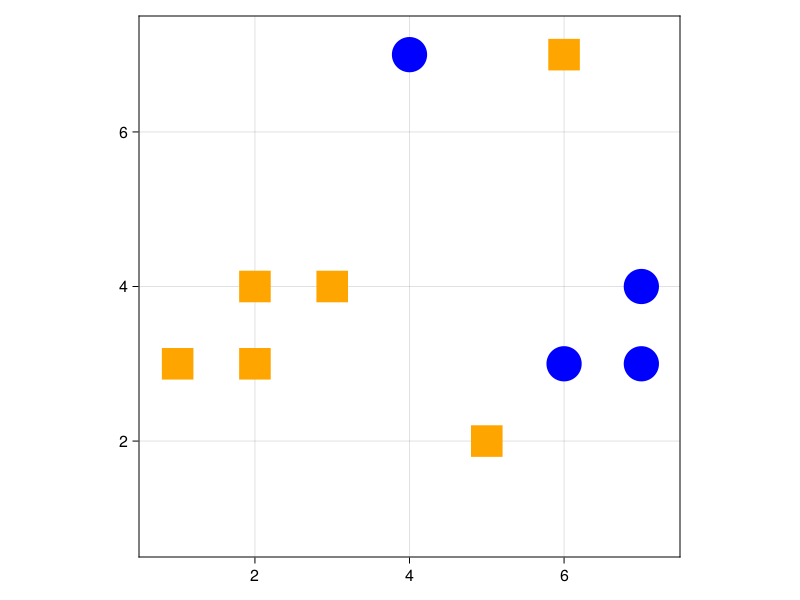

In [8]:
groupcolor(a) = a.group == 1 ? :blue : :orange
groupmarker(a) = a.group == 1 ? :circle : :rect
figure, _ = abmplot(model; ac = groupcolor, am = groupmarker, as = 50)
figure # 

### Video

In [9]:
model = initialize();
abmvideo(
    "schelling_N.mp4", model, agent_step!;
    ac = groupcolor, as = 20,
    framerate = 4, frames = 20,
    title = "Schelling  model"
)

### Collect Data

In [10]:
model = initialize()
adata = [:pos, :mood, :group]
data, _ = run!(model, agent_step!, 5; adata)
last(data,15)

Row,step,id,pos,mood,group
,Int64,Int64,Tuple…,Bool,Int64
1,4,6,"(4, 5)",false,2
2,4,7,"(4, 2)",false,2
3,4,8,"(3, 2)",false,2
4,4,9,"(2, 7)",false,2
5,4,10,"(5, 3)",false,2
6,5,1,"(7, 4)",false,1
7,5,2,"(2, 3)",false,1
8,5,3,"(2, 2)",false,1
9,5,4,"(5, 7)",false,1


In [11]:
initial_pos = first(data,10).pos
pos = last(data,10).pos

initial_gp = Graphs.SimpleGraph(length(initial_pos))
gp = Graphs.SimpleGraph(length(pos))
nodecolor = [colorant"lightseagreen", colorant"orange"]
nodefillc = nodecolor[data.group]

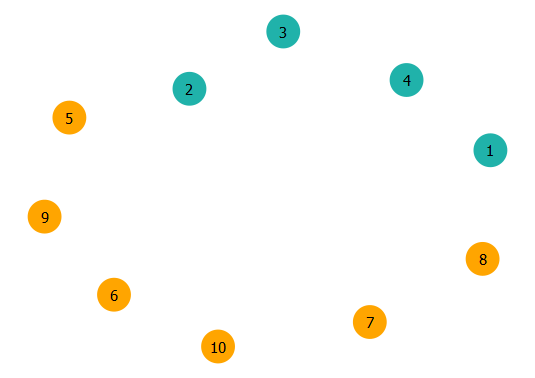

In [12]:
gplot(initial_gp,nodefillc = nodecolor[data.group], nodelabel=last(data,10).id)

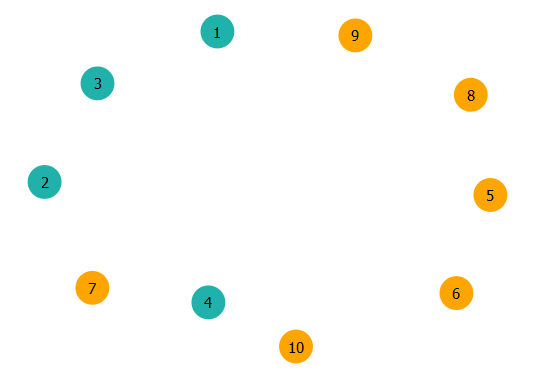

In [13]:
gplot(gp,nodefillc = nodecolor[data.group], nodelabel=last(data,10).id)

In [23]:
# Add edges based on element vector
for i in 1:length(pos)
    for j in (i + 1):length(pos)
        Agents.add_edge!(gp, i, j)
    end
end

In [25]:
gp

{10, 45} undirected simple Int64 graph

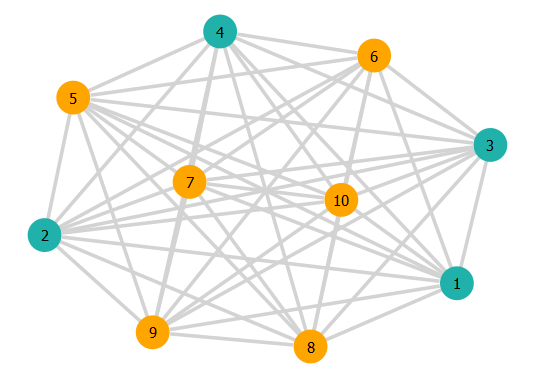

In [26]:
gplot(gp,nodefillc = nodecolor[data.group], nodelabel=last(data,10).id)

In [17]:
g = graphfamous("karate")

{34, 78} undirected simple Int64 graph

In [18]:
g.fadjlist

34-element Vector{Vector{Int64}}:
 [2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 18, 20, 22, 32]
 [1, 3, 4, 8, 14, 18, 20, 22, 31]
 [1, 2, 4, 8, 9, 10, 14, 28, 29, 33]
 [1, 2, 3, 8, 13, 14]
 [1, 7, 11]
 [1, 7, 11, 17]
 [1, 5, 6, 17]
 [1, 2, 3, 4]
 [1, 3, 31, 33, 34]
 [3, 34]
 [1, 5, 6]
 [1]
 [1, 4]
 ⋮
 [33, 34]
 [26, 28, 30, 33, 34]
 [26, 28, 32]
 [24, 25, 32]
 [30, 34]
 [3, 24, 25, 34]
 [3, 32, 34]
 [24, 27, 33, 34]
 [2, 9, 33, 34]
 [1, 25, 26, 29, 33, 34]
 [3, 9, 15, 16, 19, 21, 23, 24, 30, 31, 32, 34]
 [9, 10, 14, 15, 16, 19, 20, 21, 23, 24, 27, 28, 29, 30, 31, 32, 33]

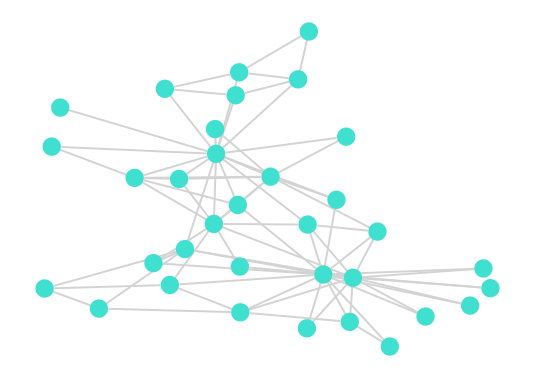

In [19]:
gplot(g)

In [20]:
model2 = initialize()
allagents(model2)

10-element Vector{SchellingAgent}:
 SchellingAgent(1, (7, 4), false, 1)
 SchellingAgent(2, (6, 3), false, 1)
 SchellingAgent(3, (7, 3), false, 1)
 SchellingAgent(4, (4, 7), false, 1)
 SchellingAgent(5, (6, 7), false, 2)
 SchellingAgent(6, (1, 3), false, 2)
 SchellingAgent(7, (2, 3), false, 2)
 SchellingAgent(8, (3, 4), false, 2)
 SchellingAgent(9, (2, 4), false, 2)
 SchellingAgent(10, (5, 2), false, 2)

In [21]:
# Add edges based on agent positions
for agent in allagents(model)
    neighbors = neighbor_indices(agent, model)
    for neighbor in neighbors
        if neighbor in vertex_ids(g)
            add_edge!(g, agent.id, vertex_index(g, neighbor))
        end
    end
end

# Visualize the graph
gplot(g, layout=circular_layout, nodelabel=1:GridSize^2, nodelabeldist=0.3, nodecolor=:group)

LoadError: UndefVarError: `neighbor_indices` not defined